In [51]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import itertools
from scipy import stats
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import matplotlib.colors as colors
import seaborn as sns

In [52]:
fig_dir = '../../paper/figs/source/freq'
ram_data_dir = '../../data/ram'

In [53]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [54]:
ram_freq_dir = os.path.join(ram_data_dir, 'freq')
pyfr_freq_dir = os.path.join(pyfr_data_dir, 'freq')

In [55]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

In [56]:
r = 20

In [72]:

freqs = ['raw', 'delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
latex_freqs = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']

freqnames = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']


In [73]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i) 
    return(colors_rgba[:N, :3])

In [74]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

## For RAM

In [75]:
## load in all frequencies as longform and wideform :

long_form_freq_ram = pd.DataFrame()
wide_form_freq_ram = pd.DataFrame()

for e, freq in enumerate(freqs):
    
    freq_df = pd.read_csv(os.path.join(ram_freq_dir, freq + '.csv'), index_col=0)
    
#     freq_locs_ram = plot.compile_df_locs(freq_df['R'])
#     corr_pyfr_locs_ram = np.atleast_2d(freq_df['across'])
    
    long_form_across = pd.DataFrame()
    long_form_across['Correlation'] = freq_df['across']
    long_form_across['Subject'] = 'a'
    long_form_across['Freq'] = latex_freqs[e]
    
    long_form_within = pd.DataFrame()
    long_form_within['Correlation'] = freq_df['within']
    long_form_within['Subject'] = 'w'
    long_form_within['Freq'] = latex_freqs[e]
    
    wide_form_temp = pd.DataFrame()
    wide_form_temp = freq_df[['across', 'within']]
    wide_form_temp['Freq'] = latex_freqs[e]

    
    long_form_freq_temp = long_form_across.append(long_form_within)
    
    long_form_freq_ram = long_form_freq_ram.append(long_form_freq_temp)
    
    wide_form_freq_ram = wide_form_freq_ram.append(wide_form_temp)
    

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
# ## load in all RAM data:
# dfs = ['W_a_a', 'W_a_all', 'W_a_w', 'W_w_a', 'W_w_all', 'W_w_w']
# long_form = plot.long_form_df(RAM_df, dfs[0])
# for df_ in dfs[1:]:
#     long_form = long_form.append(plot.long_form_df(RAM_df, df_))
# long_form_ram = long_form[long_form['Experiment']=='all']
# long_form_ram.rename(columns = {'Experiment':'Freq'}, inplace = True)
# long_form_ram.head()
# ## all RAM data to freq dataframe:
# all_df = pd.DataFrame()
# all_df['Freq'] = long_form_ram['Freq']
# all_df['within'] = long_form_ram[long_form_ram['Subject']=='w']['Correlation']
# all_df['across'] = long_form_ram[long_form_ram['Subject']=='a']['Correlation']

# long_form_freq_ram = long_form_ram.append(long_form_freq_ram)

# wide_form_freq_ram = all_df.append(wide_form_freq_ram)
# freqnames = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']

## For PyFR:

In [77]:
## load in all frequencies as longform and wideform :

long_form_freq_pyfr = pd.DataFrame()
wide_form_freq_pyfr = pd.DataFrame()

# freqs = ['delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
# latex_freqs = ["$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$gamma_L$", "$gamma_H$", 'broadband']

for e, freq in enumerate(freqs):
    
    freq_df = pd.read_csv(os.path.join(pyfr_freq_dir, freq + '.csv'), index_col=0)
    
#     freq_locs_pyfr = plot.compile_df_locs(freq_df['R'])
#     corr_pyfr_locs_pyfr = np.atleast_2d(freq_df['across'])
    
    long_form_across = pd.DataFrame()
    long_form_across['Correlation'] = freq_df['across']
    long_form_across['Subject'] = 'a'
    long_form_across['Freq'] = latex_freqs[e]
    
    long_form_within = pd.DataFrame()
    long_form_within['Correlation'] = freq_df['within']
    long_form_within['Subject'] = 'w'
    long_form_within['Freq'] = latex_freqs[e]
    
    wide_form_temp = pd.DataFrame()
    wide_form_temp = freq_df[['across', 'within']]
    wide_form_temp['Freq'] = latex_freqs[e]

    
    long_form_freq_temp = long_form_across.append(long_form_within)
    
    long_form_freq_pyfr = long_form_freq_pyfr.append(long_form_freq_temp)
    
    wide_form_freq_pyfr = wide_form_freq_pyfr.append(wide_form_temp)
    

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
# ## load in all RAM data:
# long_form_across = pd.DataFrame()
# long_form_across['Correlation'] = pyFR_df['across']
# long_form_across['Subject'] = 'a'
# long_form_across['Experiment'] = 'all'
# long_form_within = pd.DataFrame()
# long_form_within['Correlation'] = pyFR_df['within']
# long_form_within['Subject'] = 'w'
# long_form_within['Experiment'] = 'all'

# long_form_pyfr = long_form_across.append(long_form_within)
# long_form_pyfr.rename(columns = {'Experiment':'Freq'}, inplace = True)
# long_form_freq_pyfr = long_form_pyfr.append(long_form_freq_pyfr)

# all_df = pd.DataFrame()
# all_df['Freq'] = long_form_pyfr['Freq']
# all_df['within'] = long_form_pyfr[long_form_pyfr['Subject']=='w']['Correlation']
# all_df['across'] = long_form_pyfr[long_form_pyfr['Subject']=='a']['Correlation']

# wide_form_freq_pyfr = all_df.append(wide_form_freq_pyfr)

In [79]:
freqnames = ['all', "$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']

In [80]:
freqnames[1:]

['$\\delta$',
 '$\\theta$',
 '$\\alpha$',
 '$\\beta$',
 '$\\gamma_L$',
 '$\\gamma_H$',
 'broadband']

## Make color palette:

In [89]:
## make color palette:
gray = matplotlib.colors.to_rgb('gray')
light_gray = matplotlib.colors.to_rgb('lightgray')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(freqnames[1:]))
rgba = cmap_discretize(matplotlib.cm.Spectral, len(freqnames[1:]))
rgba_null = cmap_discretize(cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.Spectral),len(freqnames[1:])) 
rgba = sns.color_palette(np.vstack((gray, np.array(rgba))))
rgba_null = sns.color_palette(np.vstack((light_gray, np.array(rgba_null))))

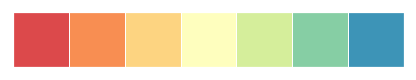

In [90]:
sns.palplot(sns.color_palette("Spectral", 7))

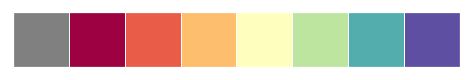

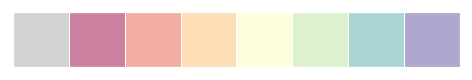

In [91]:
sns.palplot(rgba)
sns.palplot(rgba_null)

In [85]:
long_form_freq_pyfr

Correlation Subject       Freq
0        0.522524       a        all
1        0.748990       a        all
2        0.694328       a        all
3        0.272615       a        all
4        0.436093       a        all
5        0.647088       a        all
6        0.192365       a        all
7        0.130451       a        all
8        0.665264       a        all
9        0.623280       a        all
10       0.143727       a        all
11       0.638455       a        all
12       0.786089       a        all
13       0.610422       a        all
14       0.724543       a        all
15       0.523249       a        all
16       0.519597       a        all
17       0.404720       a        all
18       0.462927       a        all
19       0.786473       a        all
20       0.255122       a        all
21       0.300505       a        all
22       0.668728       a        all
23       0.442305       a        all
24       0.660014       a        all
25       0.460358       a        all
26       0.682019       a        all
27       0.241209       a        all
28       0.239073       a        all
29       0.750771       a        all
...           ...     ...        ...
4150     0.197703       w  broadband
4151     0.245542       w  broadband
4152     0.455777       w  broadband
4153     0.886986       w  broadband
4154     0.539934       w  broadband
4155     0.589114       w  broadband
4156     0.286308       w  broadband
4157     0.415633       w  broadband
4158     0.502010       w  broadband
4159     0.558924       w  broadband
4160     0.537141       w  broadband
4161     0.338728       w  broadband
4162     0.198527       w  broadband
4163     0.180936       w  broadband
4164     0.688981       w  broadband
4165     0.094567       w  broadband
4166     0.543713       w  broadband
4167     0.855567       w  broadband
4168     0.459204       w  broadband
4169     0.173835       w  broadband
4170     0.803908       w  broadband
4171     0.356649       w  broadband
4172     0.447901       w  broadband
4173     0.139598       w  broadband
4174     0.421756       w  broadband
4175     0.712934       w  broadband
4176     0.606942       w  broadband
4177     0.476540       w  broadband
4178     0.531629       w  broadband
4179     0.270273       w  broadband

[66848 rows x 3 columns]

## Jitter plots for pyfr

/Users/lucyowen/repos/supereeg_paper/code/notebooks/plot.py:801: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  offset = -.2
/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


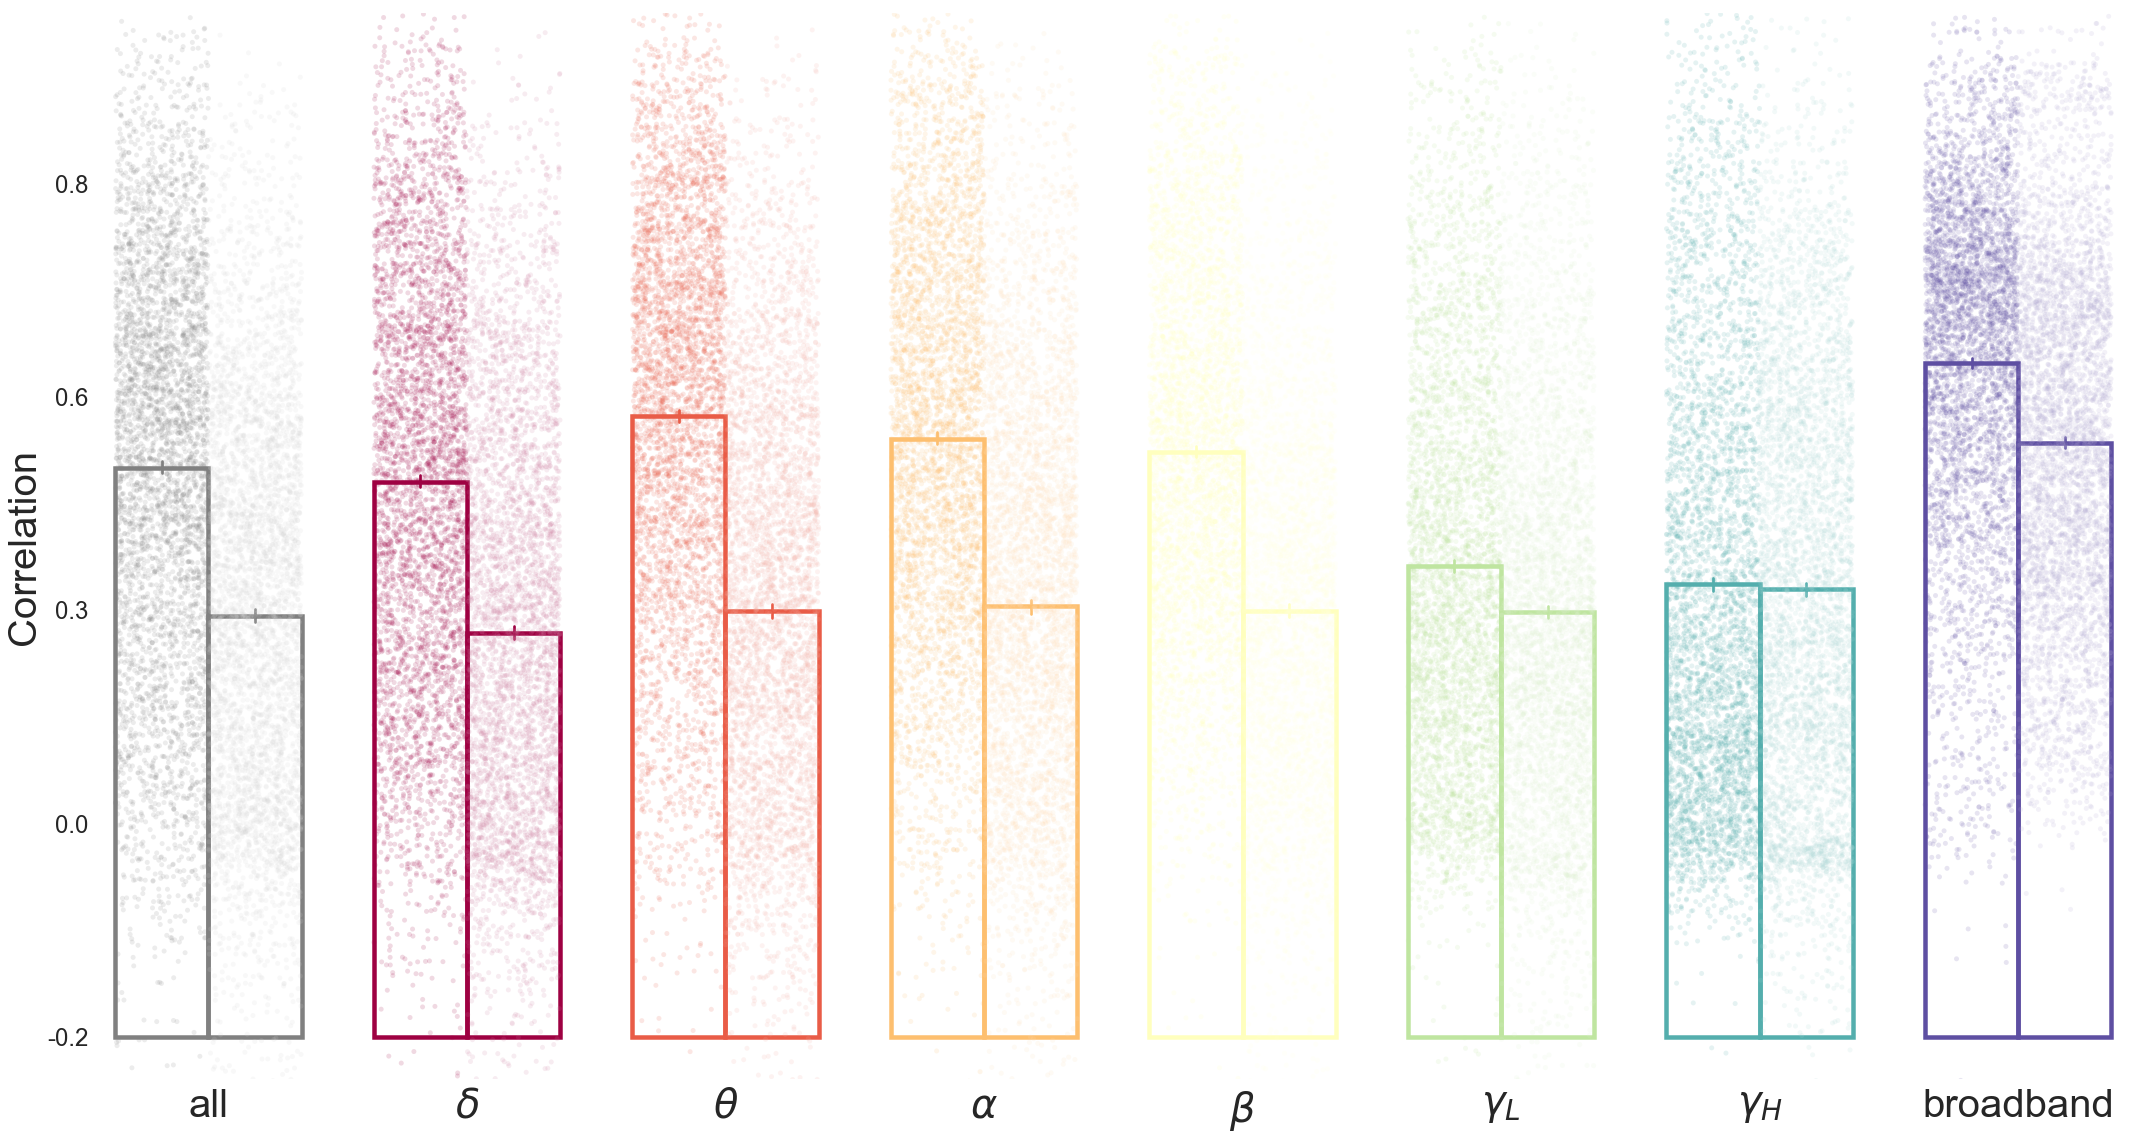

In [86]:
sns.set(style="white")
plot.plot_split_barplot_colors(df=long_form_freq_pyfr, X='Freq', Y='Correlation', H='Subject', 
                        x_order=freqnames, hue_order=['a', 'w'], left_colors=rgba, right_colors=rgba_null)

## Jitter plots for RAM

/Users/lucyowen/repos/supereeg_paper/code/notebooks/plot.py:801: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  offset = -.2
/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


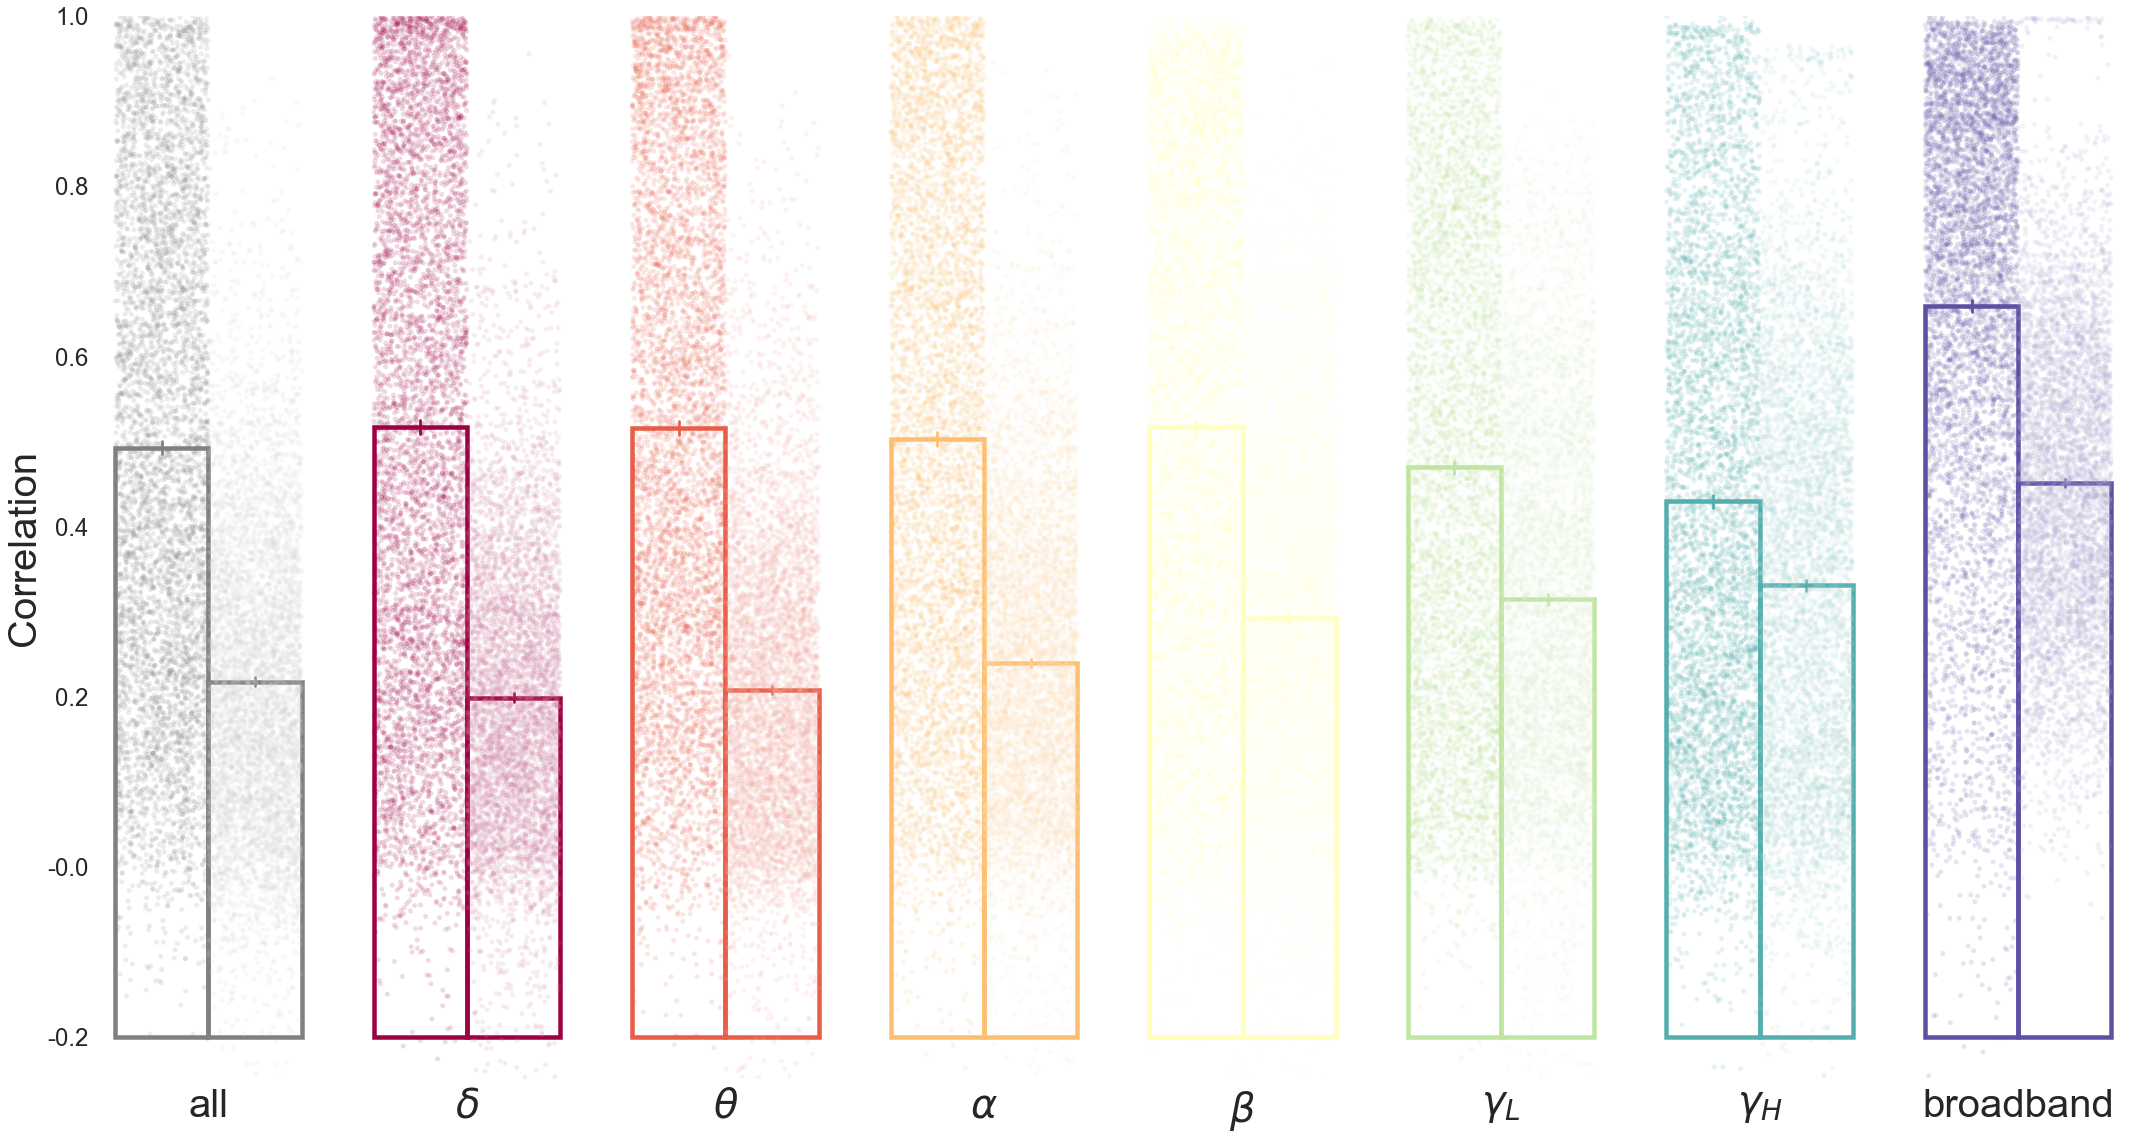

In [87]:

plot.plot_split_barplot_colors(df=long_form_freq_ram, X='Freq', Y='Correlation', H='Subject', 
                        x_order=freqnames, hue_order=['a', 'w'], left_colors=rgba, right_colors=rgba_null)

## Plot stats heatmap

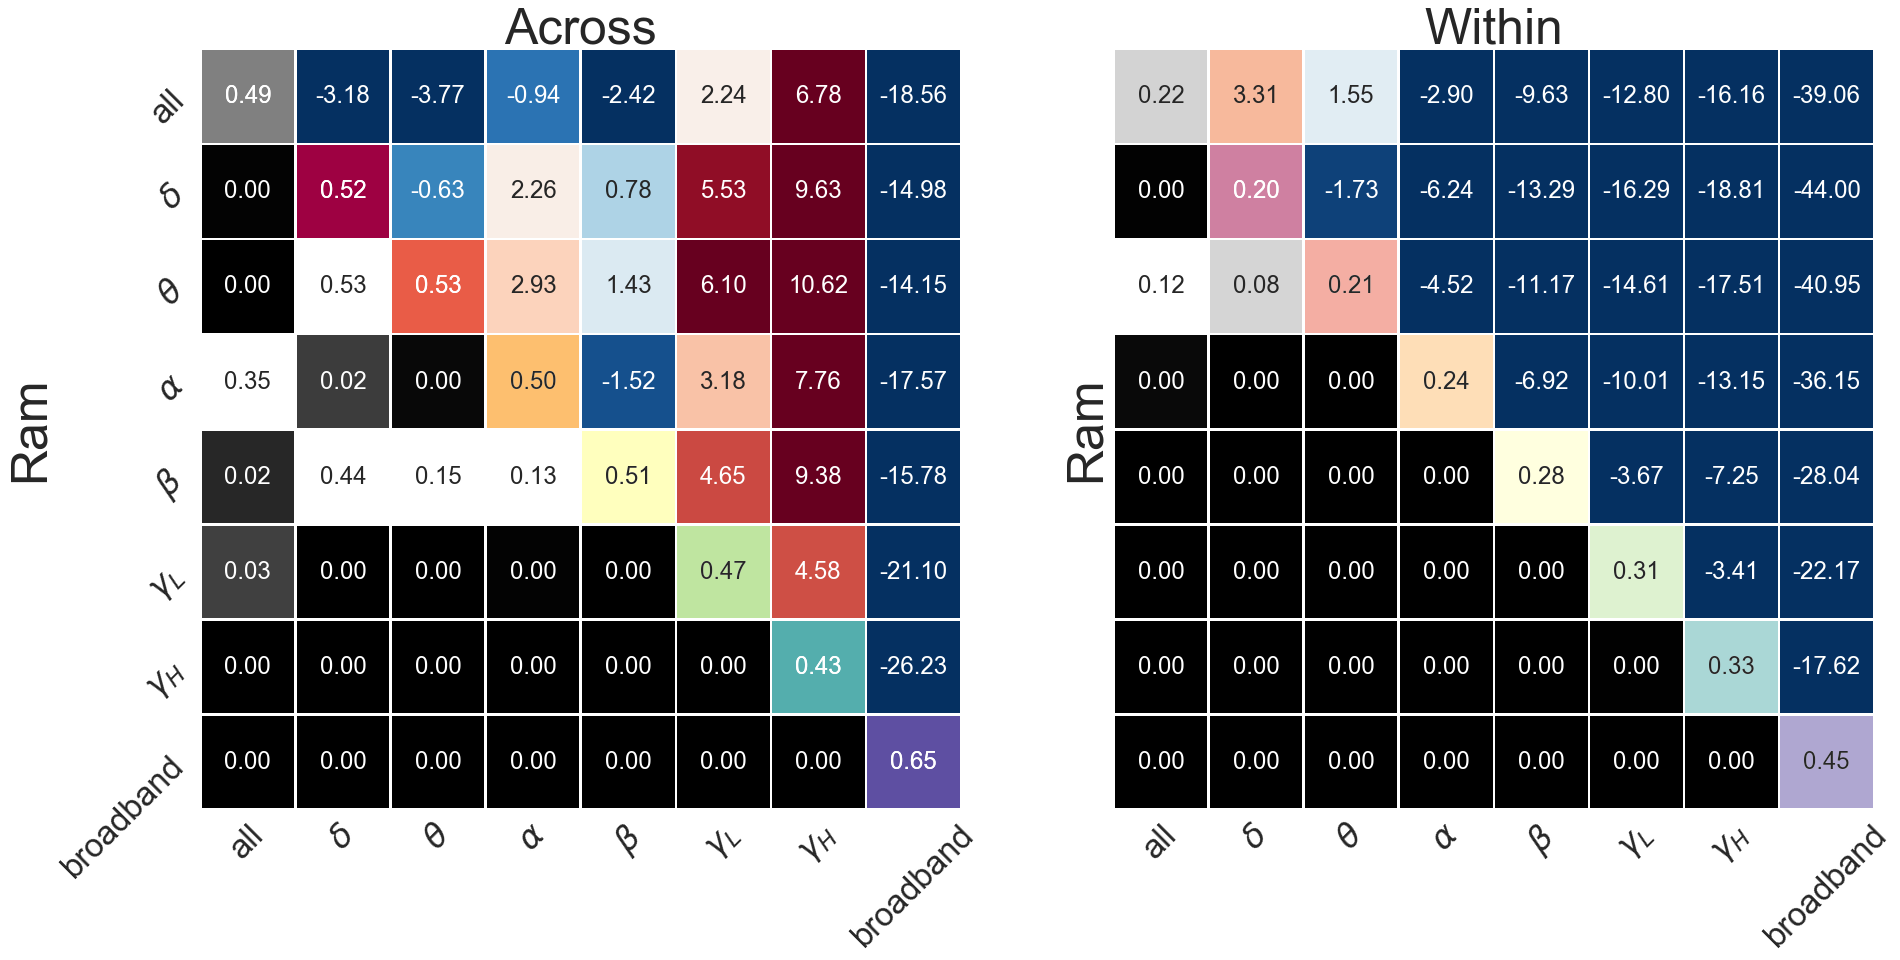

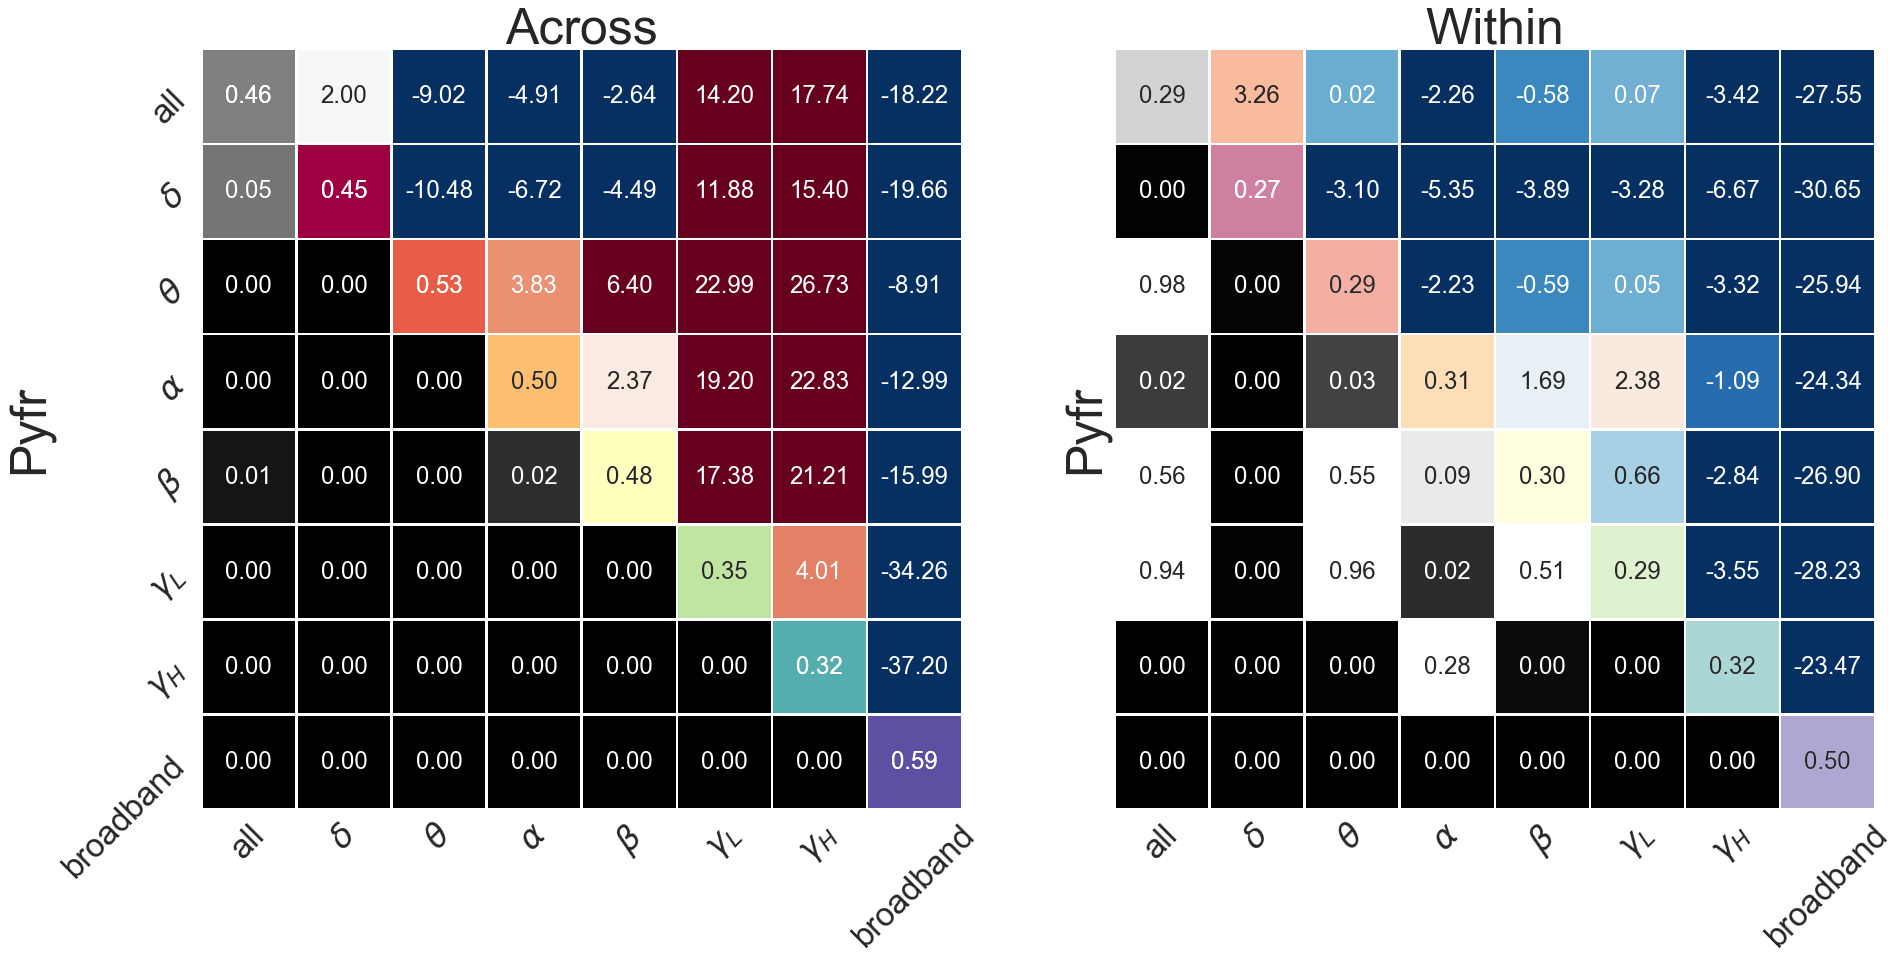

In [88]:
## This is just for the unevent values.  Once results are done and all the same number, remove the indexing 2000

freq_perms = list(range(8))
stat_dict = {}

sns.set(font_scale=3)

sub_list = ['a', 'w']
color_list = [rgba, rgba_null]
plt_title = ['Across', 'Within']

for i in ['ram', 'pyfr']:

    t_array = np.zeros((8, 8, 2))
    
    fig, axn = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(30,20))
    
    
    for e, ax in enumerate(axn.flat):
        
        exp_df = eval('long_form_freq_' + i)

        parsed_pd = exp_df[exp_df['Subject']==sub_list[e]]

        for pair in list(itertools.combinations(freq_perms, r=2)):
            
            t = stats.ttest_rel(parsed_pd[parsed_pd['Freq']==freqnames[pair[0]]]['Correlation'][:2000], 
                                parsed_pd[parsed_pd['Freq']==freqnames[pair[1]]]['Correlation'][:2000])

            t_array[pair[0], pair[1], e] = t.statistic
            t_array[pair[1], pair[0], e] = t.pvalue
            
    
        
        data = t_array[:, :, e]
        df = pd.DataFrame(data, columns=freqnames,index = freqnames)

        labels = df
        labels = labels.round(2)
        labels = labels.replace(np.nan,' ', regex=True)

        
        for f in freq_perms:
            labels.iloc[f,f] = parsed_pd[parsed_pd['Freq']==freqnames[f]]['Correlation'][:2000].mean()
            
        mask = np.triu(np.ones(df.shape)).astype(np.bool)
        
        g = sns.heatmap(df, mask=mask, cmap='binary_r',annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', square=True, linewidths=1.5, vmin=0, vmax=.1, ax=ax)
        
        mask = np.ones((8, 8))-mask
        g = sns.heatmap(df, mask=mask, cmap='RdBu_r',annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', vmin=-2, vmax=6, linewidths=1.5, ax=ax)
        
        diag_palette = color_list[e]
        
        for f in freq_perms:
            full_sq = np.ones((8,8))
            full_sq[f,f] = 0
            g = sns.heatmap(df, mask=full_sq.astype(np.bool), cmap=sns.color_palette(np.atleast_2d(diag_palette[f])),annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', vmin=0, vmax=1, linewidths=1.5, ax=ax)

        g.set_xticklabels(g.get_xticklabels(), rotation=45)
        g.set_yticklabels(g.get_xticklabels(), rotation=45) 
        g.set_title(plt_title[e], fontsize=50)
        g.set_ylabel(i.capitalize(), fontsize=50)

#     outfile = os.path.join(figdir, 'stats_heatmaps_' + i + '.pdf')
#     plt.savefig(outfile)
    plt.show()

In [47]:
# def largest_indices(ary, n):
#     """Returns the n largest indices from a numpy array."""
#     flat = ary.flatten()
#     indices = np.argpartition(flat, -n)[-n:]
#     indices = indices[np.argsort(-flat[indices])]
#     return np.unravel_index(indices, ary.shape)

In [20]:
# def smallest_indices(ary, n):
#     """Returns the n largest indices from a numpy array."""
#     flat = ary.flatten()
#     indices = np.argpartition(flat, n)[:n]
#     indices = indices[np.argsort(flat[indices])]
#     return np.unravel_index(indices, ary.shape)

In [21]:
# def rbf(centers, widths, locs):
#     """
#     Radial basis function
#     Parameters
#     ----------
#     centers : ndarray
#         rbf coordinates (one row per RBF)
#     widths : ndarray
#         RBF radii
#     locs : ndarray
#         locations to evaluate the RBFs (one row per location)
        
#     Returns
#     ----------
#     results : ndarray
#         Matrix of RBF weights for each RBF (row), at each location (column)
#     """    
#     weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
#     return weights.T

In [22]:
# template = se.helpers._gray(res=2)

In [23]:
# plot.plot_ridges(wide_form_freq_pyfr, 'Correlation', 'Freq','across', 'within', palette=rgba)

In [24]:

# for l in np.arange(0, 15, 1):
#     for c in conditions:
#         conds = glob.glob(os.path.join(data_dir, f'level_{l}', f'{c}.npy'))
#         g_m = np.load(conds[0])

#         networks = copy.copy(g_m)
#         np.fill_diagonal(networks, 0)
#         net_inds = largest_indices(np.triu(np.abs(networks)), top_n)
#         net_inds = np.concatenate((net_inds[0], net_inds[1]))
#         temp_locs = centers[net_inds]
#         temp_widths = widths[net_inds]
        
#         w = rbf(temp_locs, temp_widths, template.get_locs().values)
#         b = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
#         nii = se.Nifti(b)
#         outfile = c+ '_' + str(l+1)
#         nii.save(os.path.join(nii_dir, outfile + '_largest_abs'))
#         ni_plt.plot_glass_brain(nii, display_mode='lyrz', output_file=os.path.join(n_f_dir, outfile + '_largest_abs.png'))

In [25]:
# # split violin plots:

# plot.plot_split_violin_colors(df=long_form_freq, X='Freq', Y='Correlation', H='Subject', 
#                          x_order=freqnames, hue_order=['a', 'w'], left_colors=rgba, right_colors=rgba_null)

In [26]:
# ## Plot all correlations
# #freqnames = ['delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
# freqnames = ['delta']
# for freq in freqnames:

#     freq_df = pd.read_csv(os.path.join(ram_freq_dir, freq + '.csv'), index_col=0)


#     corr_freq_df = pd.DataFrame()
#     corr_freq_df['Subject'] = freq_df['Subject']
#     corr_freq_df['within'] = plot.r2z(freq_df['within'])
#     corr_freq_df['across'] = plot.r2z(freq_df['across'])
#     corr_freq_df['R'] = freq_df['R']

    
#     pyfr_locs = plot.compile_df_locs(freq_df['R'])
#     corr_pyfr_locs = np.atleast_2d(freq_df['across'])
    
#     print(freq)
#     print(pyfr_locs.shape)
    
# #     outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
#     outfile = None
    
#     #plot.interp_corr(pyfr_locs, np.atleast_2d(corr_pyfr_locs), width=2, vox_size=2, outfile=outfile)

In [27]:
# Plot all interp correlations

# freqnames = ['delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
# for freq in freqnames:
#     freq_df = pd.read_csv(os.path.join(freq_dir, freq + '.csv'), index_col=0)
#     grouped_freq_mean = freq_df.groupby('Subject')['across','within'].mean()
#     corr_by_subject = np.array([])
#     R_locs = []
#     subj_by_subject = np.array([])
#     for i, s in enumerate(grouped_freq_mean.index):


#         sub_locs = plot.compile_df_locs(freq_df['R'][freq_df['Subject'] == s])

#         if R_locs == []:
#             R_locs = sub_locs 
#         else:

#             R_locs = np.vstack((R_locs, sub_locs))

#         sub_corr = np.atleast_2d(grouped_freq_mean['across'][i])

#         corr_by_subject = np.append(corr_by_subject, np.array([grouped_freq_mean['across'][i]]* np.shape(sub_locs)[0]))

#         subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



#     bestloc_pyfr_df = pd.DataFrame()
#     bestloc_pyfr_df['Correlation'] = plot.z2r(corr_by_subject)
#     bestloc_pyfr_df['Subject'] = subj_by_subject
#     bestloc_pyfr_df['R'] = None

#     R_locs_str = []
#     for i in range(bestloc_pyfr_df.shape[0]):
#         R = str(R_locs[i])
#         if R_locs_str == []:
#             R_locs_str = R
#         else:

#             R_locs_str = np.vstack((R_locs_str, R))

#     bestloc_pyfr_df['R'] = R_locs_str
    
#     most_info_pyfr = plot.most_informative_locs(bestloc_pyfr_df, vox_size=4, width=r)
#     #best_locs_mask = pd.DataFrame()
#     #best_locs_mask['PyFR'] = most_info_pyfr
#     #pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 90)
#     sub_nii = se.load('std', vox_size=4)
#     sub_locs = sub_nii.get_locs().values
#     bo_nii = se.Brain(data=np.atleast_2d(most_info_pyfr), locs=sub_locs)
#     nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
#     ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
#     ni_plt.show()

In [ ]:
pd.DataFrame()